#  Laboratorium z Podstaw Przetwarzania Sygnałów
## Laboratorium 6 - Filtrowanie i Konwolucja

prowadzący: dr inż. Łukasz Jeleń  
  
Dzisiejsze zadania pochodzą z Allen B. Downey, Think DSP, Digital Signal Processing in Python, Green Tea Press, Wersja 1.0.5

Nazwisko i Imię: Jan Zieniewicz  
Nr albumu: 263930  
data wykonania ćwiczenia: 20.12.2022   

w celu zachowania przeniesienia do kolejnej linii należy się upewnić, że na końcu linii znajduje się 2x spacja

## Zestaw narzędzi  

Na poprzednich zajęciach poznali Państwo narzędzia udostępnionne przez Autora podręcznika "Think DSP". W poniższej komórce macie Państo dane do ich pobrania - dla przypomnienia. 

In [ ]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

np.set_printoptions(precision=3, suppress=True)

: 

## 1. Wygładzenie sygnału 

Wygładzenie (smoothing) to operacja, która usuwa krótkotrwałe zmiany z sygnału w celu uwydatnienia tych długotrwałych. Dla przykładu, jeśli wyświtlilibyśmy na wykresie dzienne zmiany cen akcji, to wyglądałyby one na zaszumione. Zastosowanie operatora wygładzającego może uwypuklić ogólny trend czasowy (rośnie, maleje).  
  
Popu;arnym algorytmem wygładzającym jest średnia krocząca, która wyznacza średnią $n$ pierwszych wartości, dla zadanej wartości $n$.  
  
Zaczniemy od przykładu cen zamknięcia dla Facebooka w okresie 2012-05-18 to 2020-03-27

In [3]:
if not os.path.exists('FB_2.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv

In [4]:
import pandas as pd

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


Przefiltrujemy teraz dane w celu uzyskania ceny zamknięcia oraz dni od początku serii. 

In [5]:
close = df['Close']
dates = df['Date']
days = (dates - dates[0]) / np.timedelta64(1,'D')

Utworzymy teraz okno, w którym będziemy wyznaczanli średnią kroczącą dla okresu 30 dniowego. Tak utworzone okno będziemy splatali (konwolucja) z naszymi danymi. Z uwagi na tzw. problem brzegowy zastosujemy flagę `valid`, która rozwiązuje ten problem poprzez rozpoczęcie wyznaczania splotu tylko w sytuacji, w której stworzone przez nas okno będzie się całkowicie pokrywało z sygnałem.  
  
W kolejnym kroku wyświetlimy sygnał przed i po wygładzeniu. 

In [6]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode='valid')
smoothed_days = days[M//2: len(smoothed) + M//2]

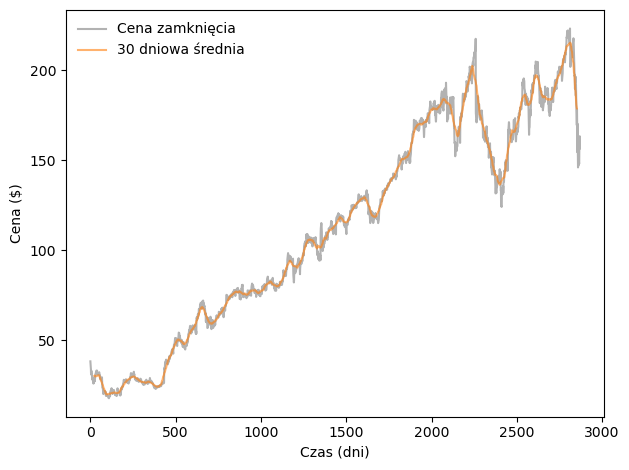

In [7]:
plt.plot(days, close, color='gray', alpha=0.6, label='Cena zamknięcia')
plt.plot(smoothed_days, smoothed, color='C1', alpha=0.6, label='30 dniowa średnia')

decorate(xlabel='Czas (dni)', ylabel='Cena ($)')

### Wygładzanie sygnałów dźwiękowych

Zastosujemy powyższe podejście do sygnału dźwiękowego. Zaczniemy od wygenerowania sygnału piłokształtnego o częstotliwości 440 Hz, następnie utworzymy okno dla średniej kroczącej oraz wyświetlimy wygenerowany sygnał. 

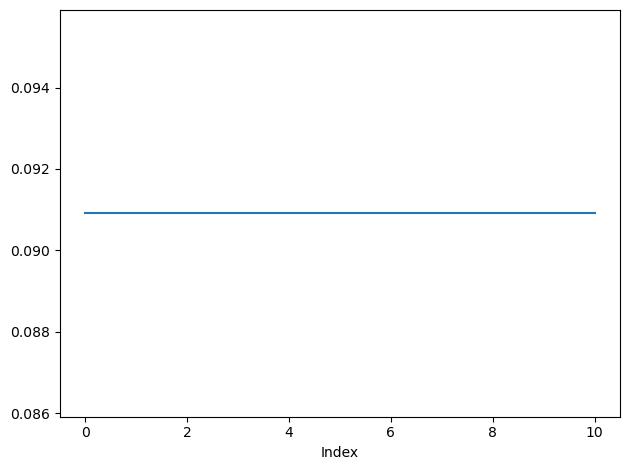

In [8]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)
wave.make_audio()

window = np.ones(11)
window /= sum(window)
plt.plot(window)
decorate(xlabel='Index')

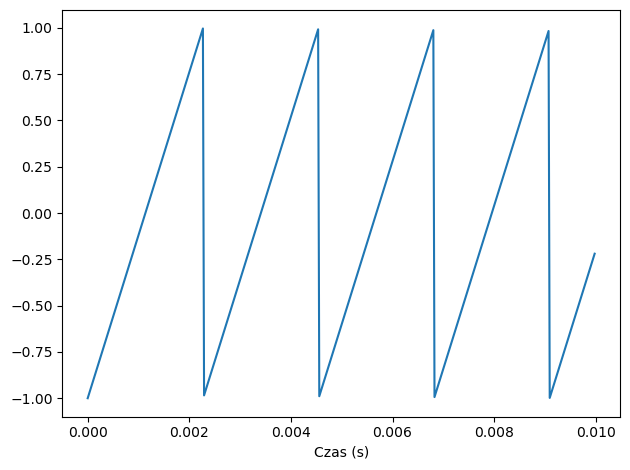

In [9]:
segment = wave.segment(duration=0.01)
segment.plot()
decorate(xlabel='Czas (s)')

Dokonamy teraz rozszerzenia okna do rozmiaru sygnału (zero-padding)

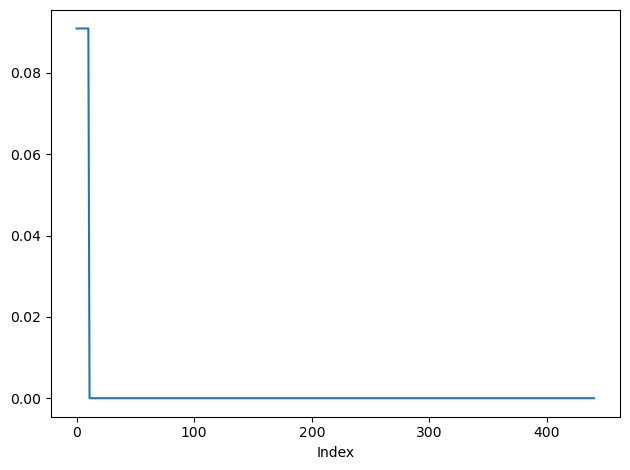

In [10]:
def zero_pad(array, n):
    """Rozszerza okno wypełniając je zerami.

    array: NumPy array
    n: rozmiar wyjścia

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

N = len(segment)
padded = zero_pad(window, N)
plt.plot(padded)
decorate(xlabel='Index')

Nałożymy okno na sygnał i dokonamy splotu krocząc w prawo.

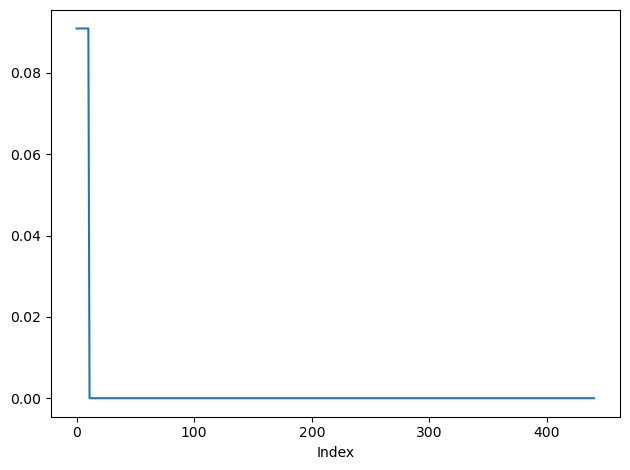

In [11]:
prod = padded * segment.ys
np.sum(prod)

smoothed = np.zeros(N)
rolled = padded.copy()
for i in range(N):
    smoothed[i] = sum(rolled * segment.ys)
    rolled = np.roll(rolled, 1)
    
plt.plot(rolled)
decorate(xlabel='Index')

Wyświetlmy rezultat

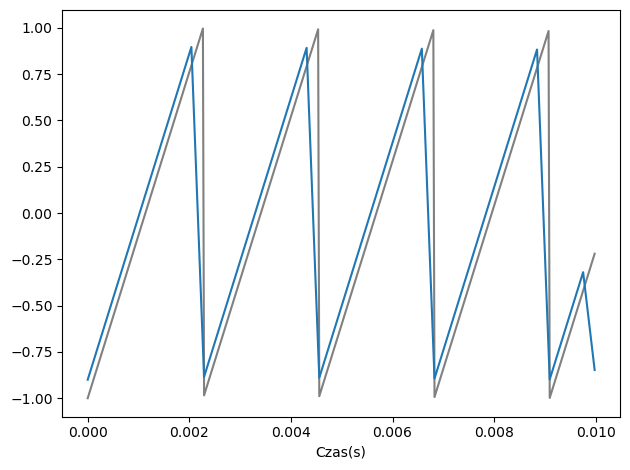

In [12]:
from thinkdsp import Wave

segment.plot(color='gray')
smooth = Wave(smoothed, framerate=wave.framerate)
smooth.plot()
decorate(xlabel='Czas(s)')

Teraz policzymy splot z wykorzystaniem `numpy.convolve`

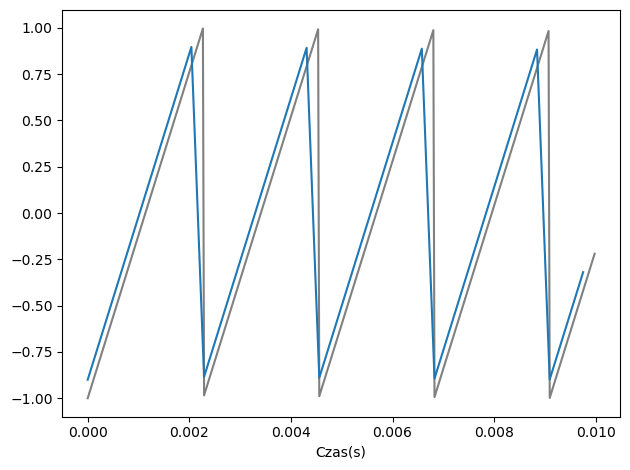

In [13]:
segment.plot(color='gray')
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = Wave(ys, framerate=wave.framerate)
smooth2.plot()
decorate(xlabel='Czas(s)')

### Dziedzina częstotliwościowa  
  
Dokonajmy wygładzenia fali za pomocą `np.convolve`, która jest znacznie szybsza niż metoda podawana wcześniej. W kolejnym kroku wyświetlimy spektrum. 


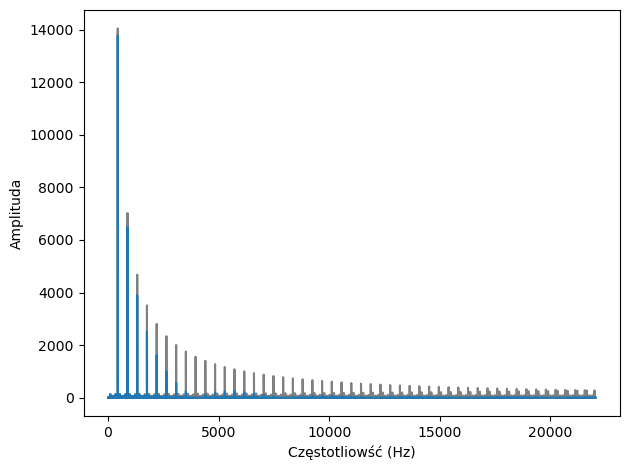

In [14]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = Wave(convolved, framerate=wave.framerate)
smooth.make_audio()

spectrum = wave.make_spectrum()
spectrum.plot(color='gray')

spectrum2 = smooth.make_spectrum()
spectrum2.plot()

decorate(xlabel='Częstotliowść (Hz)', ylabel='Amplituda')

A dla każdej harmonicznej wyznaczymy stosunek amplitudy przez i po wygładzeniu. Na kolejnym wykresie zaznaczymy także FFT dla okna. 

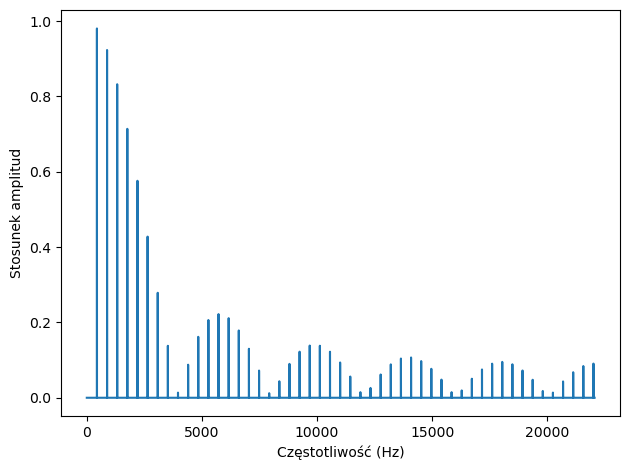

In [15]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<280] = 0

plt.plot(ratio)
decorate(xlabel='Częstotliwość (Hz)', ylabel='Stosunek amplitud')

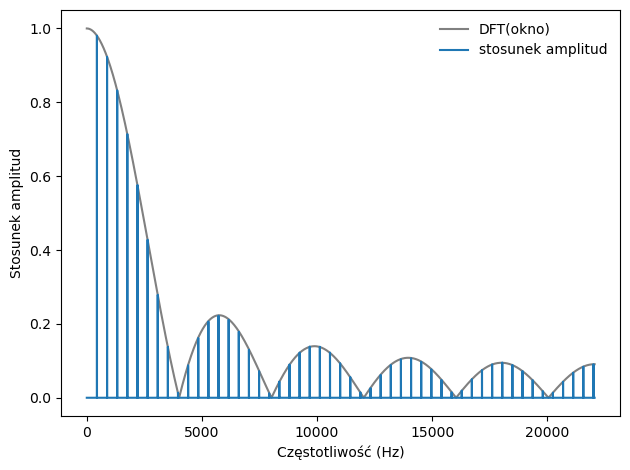

In [16]:
padded =  zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)

plt.plot(np.abs(dft_window), color='gray', label='DFT(okno)')
plt.plot(ratio, label='stosunek amplitud')

decorate(xlabel='Częstotliwość (Hz)', ylabel='Stosunek amplitud')

### Okno Gaussowskie  
  
Porównamy okno kwadratowe oraz Gaussowskie. Najpier utworzymy okno kwadratowe, potem Gausowskie i wyświetlimy je na wykresie. 

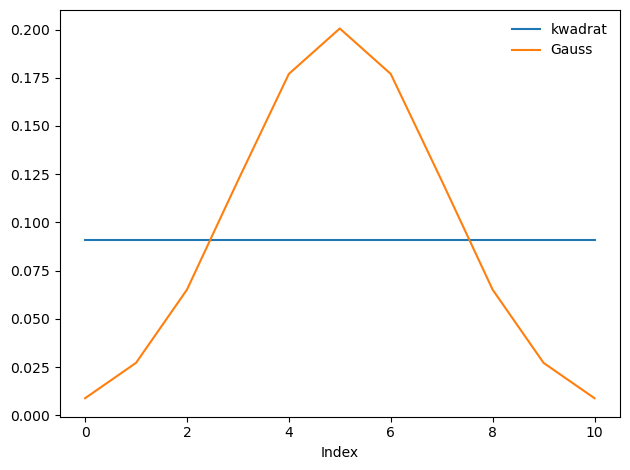

In [17]:
boxcar = np.ones(11)
boxcar /= sum(boxcar)

import scipy.signal

gaussian = scipy.signal.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

plt.plot(boxcar, label='kwadrat')
plt.plot(gaussian, label='Gauss')
decorate(xlabel='Index')

Teraz wyznaczymy ich splot, stosunek amplitud oraz FFT dla okna i wyświtlimy rezultaty na wykresie

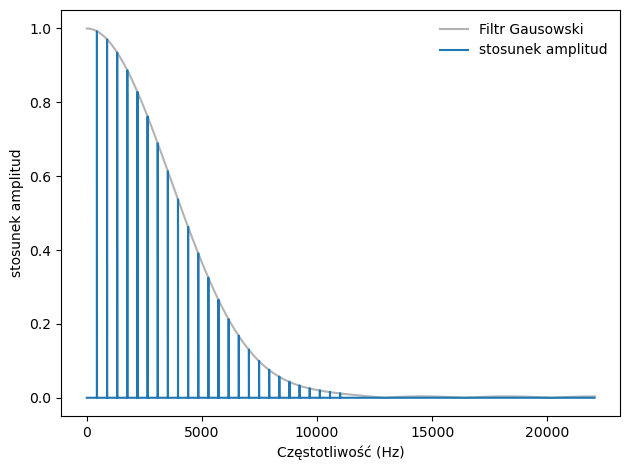

In [18]:
ys = np.convolve(wave.ys, gaussian, mode='same')
smooth = Wave(ys, framerate=wave.framerate)
spectrum2 = smooth.make_spectrum()

amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<560] = 0

padded =  zero_pad(gaussian, len(wave))
dft_gaussian = np.fft.rfft(padded)

plt.plot(np.abs(dft_gaussian), color='0.7', label='Filtr Gausowski')
plt.plot(ratio, label='stosunek amplitud')

decorate(xlabel='Częstotliwość (Hz)', ylabel='stosunek amplitud')

Powyższy kod możemy zebrać i zapisać w postaci funkcji, którą można potem wykorzystać. 

In [19]:
from thinkdsp import SquareSignal

def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Filtr Gausowski')
    plt.plot(ratio, label='stosunek amplitud')

    decorate(xlabel='Częstotliwość (Hz)', ylabel='stosunek amplitud')
    plt.show()

Można przetestować dla różnych wartości `M` oraz `std`

In [20]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

### Twierdzenie konwolucji (splotu)  

Wykorzystamy twierdzenie konwolucji do wtyznaczenia splotu przy pomocy FFT. W tym celu ponownie posłużymy się danymi Facebooka, które wygładzimy wykorzystując `np.convolve` dla 30-dniowego okna Gausowskiego. 

In [21]:
window = scipy.signal.gaussian(M=30, std=6)
window /= window.sum()
smoothed = np.convolve(close, window, mode='valid')

len(close), len(smoothed)

(1977, 1948)

Wyświetlmy oryginał oraz wersję wygładzoną

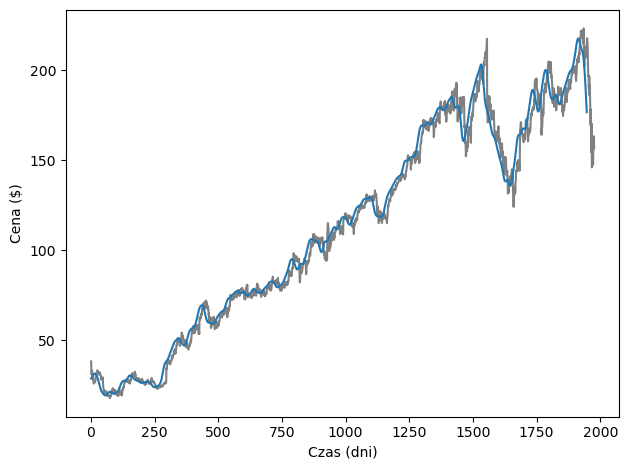

In [22]:
plt.plot(close, color='gray')
plt.plot(smoothed)
decorate(xlabel='Czas (dni)', ylabel='Cena ($)')

Czas na FFT oraz zastosowanie twierdzenia konwolucyjnego

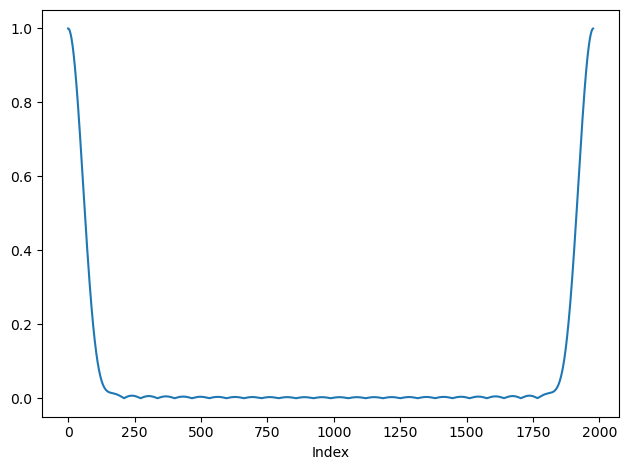

In [23]:
N = len(close)
padded = zero_pad(window, N)
fft_window = np.fft.fft(padded)
plt.plot(np.abs(fft_window))
decorate(xlabel='Index')

fft_signal = np.fft.fft(close)
smoothed2 = np.fft.ifft(fft_signal * fft_window)
M = len(window)
smoothed2 = smoothed2[M-1:]

Wyświtlmy sygnały (wygładzony z numpy oraz FFT)

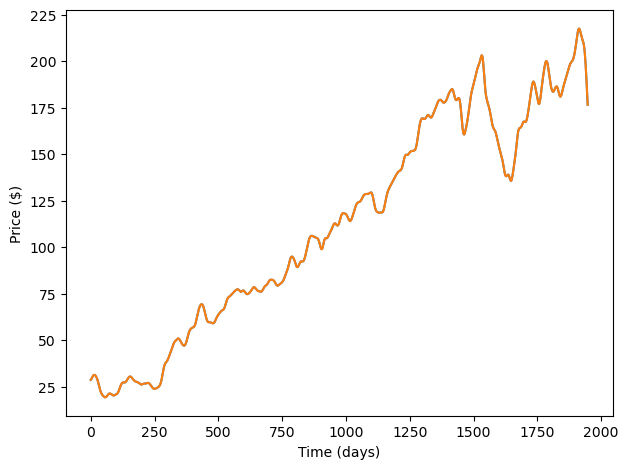

In [24]:
plt.plot(smoothed)
plt.plot(smoothed2.real)
decorate(xlabel='Time (days)', ylabel='Price ($)')

Dla pewności sprawdzimy, czy różnica jest znacząca...

In [25]:
diff = smoothed - smoothed2
np.max(np.abs(diff))

2.2806650926133947e-13

nie była.  
  
`scipy.signal` zawiera funkcję `fftconvolve`, która wyznacza splot za pomocą FFT

In [26]:
smoothed3 = scipy.signal.fftconvolve(close, window, mode='valid')

dla potwierdzenia

In [27]:
diff = smoothed - smoothed3
np.max(np.abs(diff))

1.4210854715202004e-13

Ponownie możemy zebrać to w funkcję i sprawdzić, czy uzyskamy taki sam rezultat. 

In [28]:
def fft_convolve(signal, window):
    fft_signal = np.fft.fft(signal)
    fft_window = np.fft.fft(window)
    return np.fft.ifft(fft_signal * fft_window)

smoothed4 = fft_convolve(close, padded)[M-1:]
len(smoothed4)

1948

In [29]:
diff = smoothed - smoothed4
np.max(np.abs(diff))

2.2806650926133947e-13

### Autokorelacja  
  
Twierdzenie konwolucyjne możemy także wykorzystać do wyznaczenia funkcji autokorelacji. Zobaczmy. Na początek wyznaczymy autokorelację za pomocą `np.correlate`, a następnie przy pomocy `fft_convolve`. 

In [30]:
corrs = np.correlate(close, close, mode='same')
corrs[:7]

array([10515607.461, 10533254.812, 10550927.762, 10570279.165,
       10589752.032, 10609151.979, 10628488.485])

In [31]:
def fft_autocorr(signal):
    N = len(signal)
    signal = zero_pad(signal, 2*N)
    window = np.flipud(signal)

    corrs = fft_convolve(signal, window)
    corrs = np.roll(corrs, N//2+1)[:N]
    return corrs

Analogicznie jak poprzednio sprawdzimy działanie funkcji, wyświtlimy rezultaty oraz potwierdzimy, że różnica jest niewielka. 

(1977, 1977)

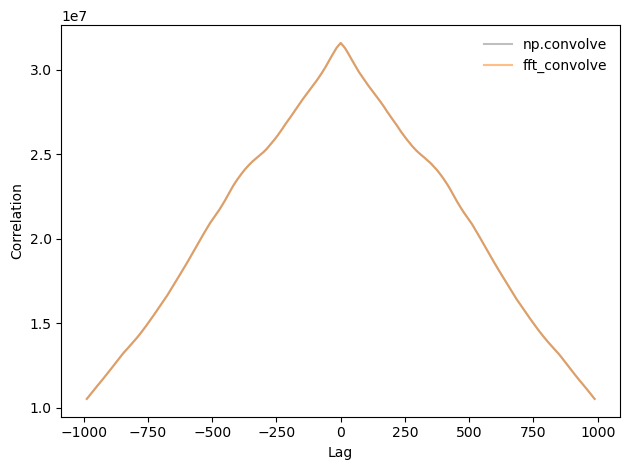

In [32]:
corrs2 = fft_autocorr(close)
corrs2[:7]

lags = np.arange(N) - N//2
plt.plot(lags, corrs, color='gray', alpha=0.5, label='np.convolve')
plt.plot(lags, corrs2.real, color='C1', alpha=0.5, label='fft_convolve')
decorate(xlabel='Lag', ylabel='Correlation')
len(corrs), len(corrs2)

In [33]:
diff = corrs - corrs2.real
np.max(np.abs(diff))

3.3527612686157227e-08

## 3. Zadania

#### Zadanie 1  
  
Z wykładu wiemy, że transformata Fouriera krzywej Gusowskiej jest także krzywą Gausowską, co dla dyskretnej transformaty Fouriera jest w przybliżeniu prawdą. 
Proszę przetestować to stwoerdzenie na kilku przykładach (min 3.). Co się stanie z transformatą Fouriera jak zaczniecie Państwo modyfikować parametr `std`?

In [45]:
import thinkdsp 
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal


def zadanie1(M , std):

    squareSig= thinkdsp.SquareSignal(freq=440)
    wave = squareSig.make_wave(duration=1, framerate=44100)
    spec= wave.make_spectrum()
    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    plt.plot(gaussian)
    plt.show()
    ys = np.convolve(wave.ys,gaussian,mode='same')
    smooth = thinkdsp.Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()
    amps = spec.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0
    padded =  thinkdsp.zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)
    plt.plot(np.abs(dft_gaussian), color='gray', label='Filtr Gausowski')
    plt.plot(ratio, label='stosunek amplitud')
    plt.show()

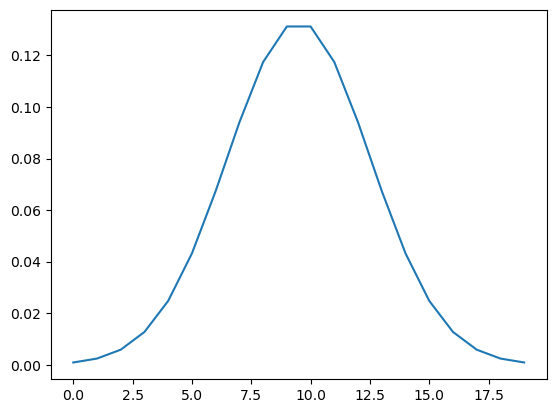

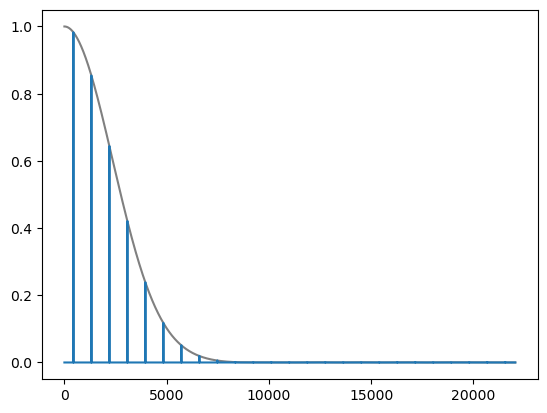

In [46]:
zadanie1(20,3)

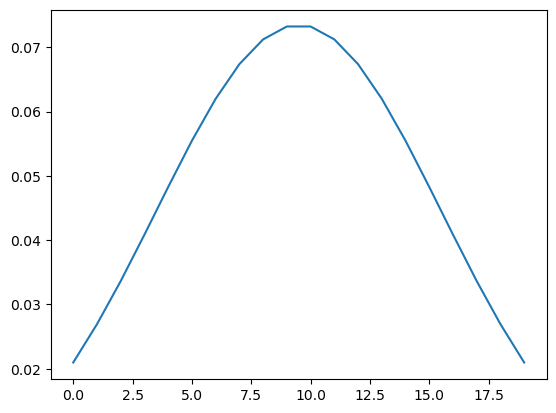

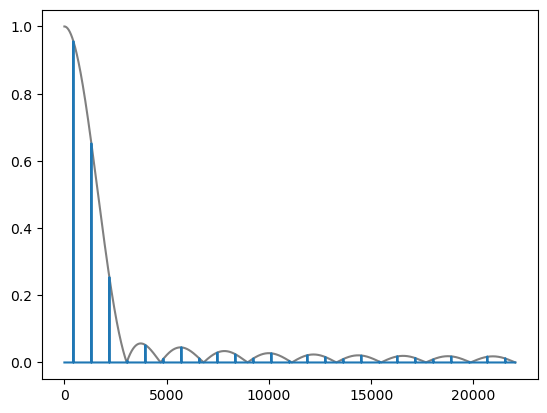

In [41]:
zadanie1(20,6)

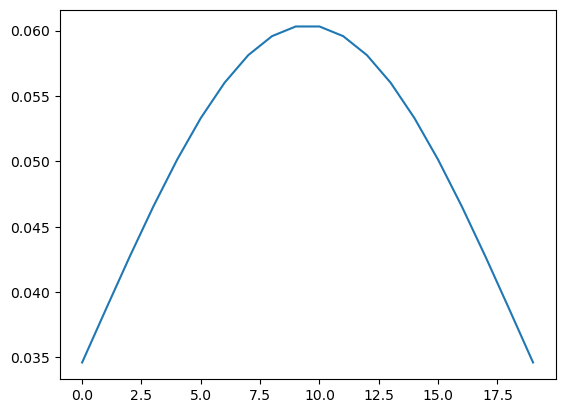

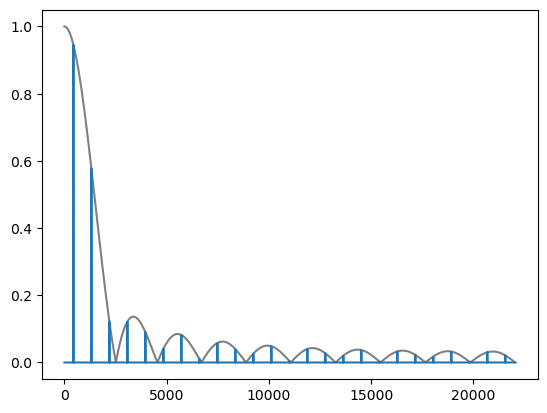

In [42]:
zadanie1(20,9)

Odp.:  
Ze zwiększeniem parametru std okno gaussowskie wygładza się i staje się mniej kanciaste. Na wykresie stosunków pojawia się więcej wybrzuszeń, które potem rosną.

#### Zadanie 2  
 
W poprzednich przykładach można było zauważyć wpływ okna Hamminga oraz innych dostępnych w numpy na tzw. spectral leakage (efekt opracji tworzącej nowe składowe częstotliwości). Więcej szczegółów tego efektu można zaobserwować w DFT. 
Należy stworzyć okno Hamminga o takim samym rozmiarze jak okno Gausowskie oraz wykonać analogiczne kroki prowadzące do wygładzenia sygnału oraz wyświetlenia jego DFT. 
Które z okien jest lepszym filtrem dolnoprzepustowym? Pomocne może się okazać wykonanie wykresów w skali logartymnicznej. Przeprowadź analizę dla kilku różnych okien o róznych rozmiarach (min. 3). 

In [47]:
import thinkdsp 
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd

def zadanie2():
    df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
    df.head()
    np.set_printoptions(precision=3, suppress=True)
    df.tail()
    close = df['Close']
    dates = df['Date']
    window = scipy.signal.gaussian(M=30, std=6)
    window /= sum(window)
    smoothed = np.convolve(close, window, mode='valid')
    plt.plot(close, color='red')
    plt.plot(smoothed)
    plt.show()
    N = len(close)
    M = len(window)
    padded = thinkdsp.zero_pad(window, N)
    fft_window = np.fft.fft(padded)
    fft_signal = np.fft.fft(close)
    smoothed2 = np.fft.ifft(fft_signal * fft_window)
    smoothed2 = smoothed2[M-1:]
    plt.plot(np.abs(fft_window))
    plt.plot(smoothed,color='yellow')
    plt.show()
    plt.plot(smoothed2.real)
    plt.show()
    diff = smoothed - smoothed2
    np.max(np.abs(diff))
    smoothed3 = scipy.signal.fftconvolve(close, window, mode='valid')
    diff = smoothed - smoothed3
    np.max(np.abs(diff))
    plt.plot(diff)
    plt.show()

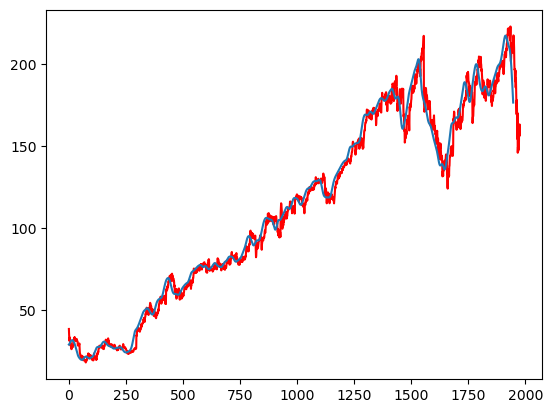

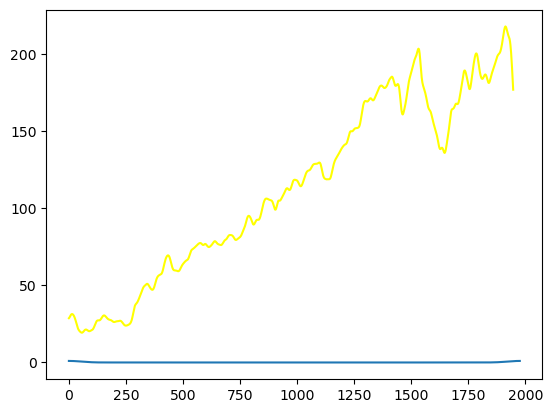

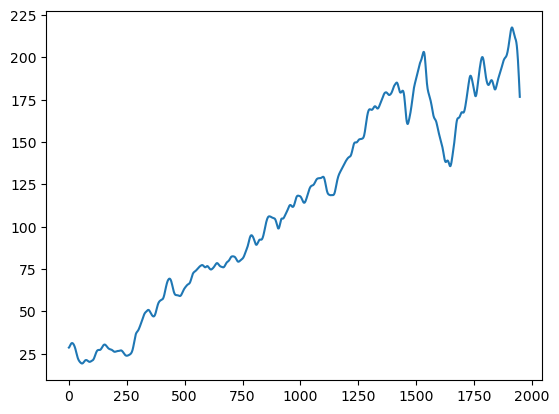

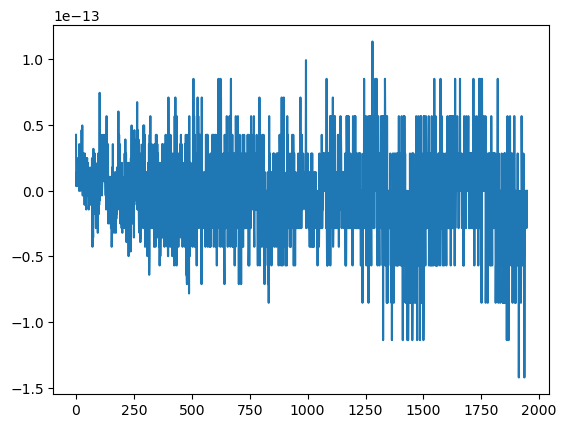

In [48]:
zadanie2()